In [1]:
from stabletrees import BaseLineTree, AbuTreeI, NaiveUpdate,TreeReevaluation,StabilityRegularization,BootstrapUpdate
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split,RepeatedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_poisson_deviance, mean_squared_error

SEED = 0

# Poisson
# $\lambda = \log(X_1)\sim Unif(0,4)$

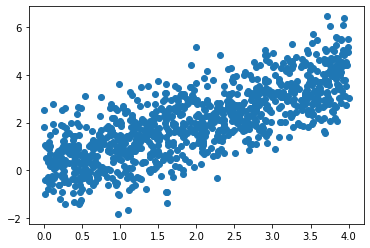

In [2]:
n = 1000
np.random.seed(SEED)
X = np.random.uniform(low=0,high=4,size=n).reshape(-1,1)
y = np.random.normal(loc=X.ravel(),scale=1,size=n)
plt.scatter(X,y)
plt.show()

In [22]:
kf = RepeatedKFold(n_splits= 5,n_repeats=20, random_state=SEED)
criterion = "mse"
models = {  
                "baseline": BaseLineTree(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True),
                "NU": NaiveUpdate(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True,),
                "TR":TreeReevaluation(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True, delta=0.1),
                "SR":StabilityRegularization(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True,lmbda=0.75),
                "ABU":AbuTreeI(criterion = criterion,min_samples_leaf=5,adaptive_complexity=True),
                "iABU": BootstrapUpdate(criterion = criterion,min_samples_leaf=5,adaptive_complexity=True)
                
                #  "baseline": BaseLineTree(**params), 
                # "NU": StableTree0(**params),
                #  "TR":TreeReevaluation(criterion = criterion,**params, delta=0.1)
                #  #"SR":StableTree2(**params,lmda=0.5),
                #  "ABU":AbuTreeI(**params)
                }

preds  = {k :np.zeros((200,100)) for k in models.keys()}
stability = {k :[] for k in models.keys()}
performance = {k :[] for k in models.keys()}
for i,(train_index, test_index) in enumerate(kf.split(X)):
        X_12, y_12 = X[train_index],y[train_index]
        X_test,y_test = X[test_index],y[test_index]
        X_test = np.sort(X_test)
        X1,X2,y1,y2 =  train_test_split(X_12, y_12, test_size=0.5, random_state=SEED)
        for name, model in models.items():
                model.fit(X1,y1)
                pred1 = model.predict(X_test)
                model.update(X_12,y_12)
                pred2 = model.predict(X_test)
                preds[name][:,i] = (pred1-pred2)**2
                stability[name].append( np.mean((pred1-pred2)**2))
                performance[name] = mean_squared_error(y_test, pred2)


0.07992678941909051
0.008126963941801032
0.009836532996779886
0.00404764207237513
0.0641669290598856


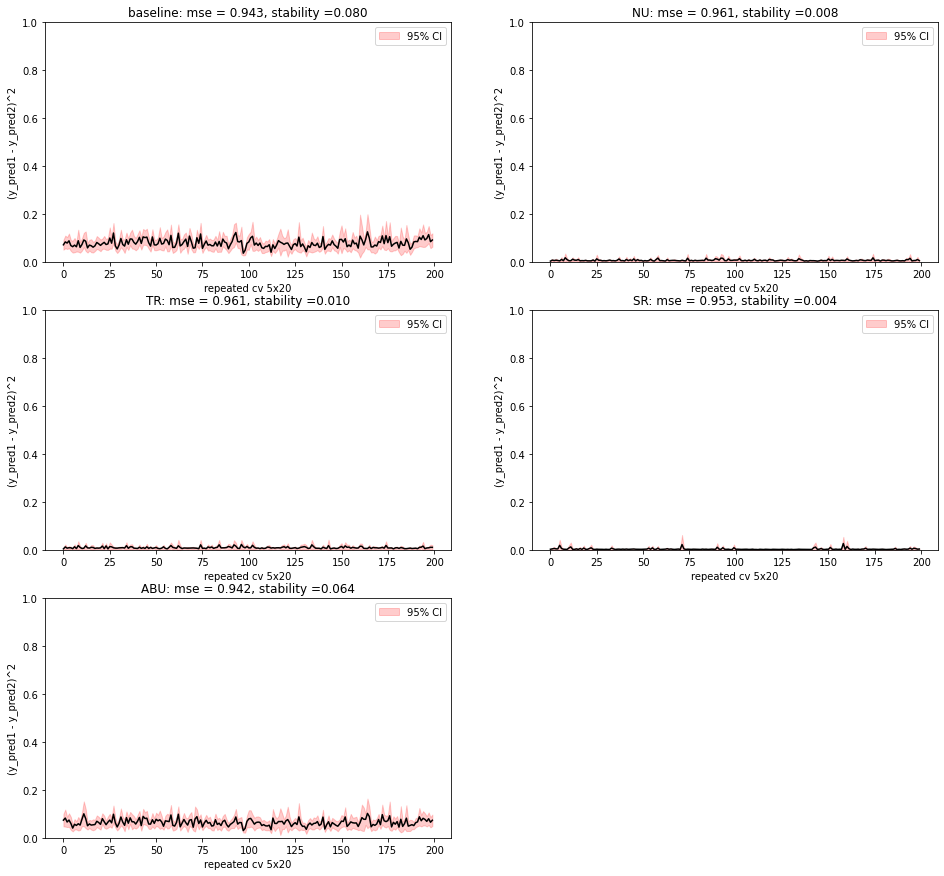

In [4]:
fig = plt.figure(figsize=(16, 15))
for i, (name, model) in enumerate(models.items()):
    plt.subplot(3,2,i+1)

    y_mean = np.mean(preds[name],axis=1)
    y_std = np.std(preds[name],axis=1)
    ci = 1.96 * y_std / np.sqrt(preds[name].shape[1])
    plt.plot(np.arange(0,preds[name].shape[0],1), y_mean, color = "black")
    plt.fill_between(np.arange(0,preds[name].shape[0],1), y_mean-ci, y_mean+ci, alpha=0.2, label='95% CI', color = "red", interpolate=True)
    plt.ylim((0,1))
    # Set the plot title and axis labels
    plt.title('Line plot with error bars')
    plt.xlabel('repeated cv 5x20')
    plt.ylabel('(y_pred1 - y_pred2)^2')
    plt.title(f'{name}: mse = {np.mean(performance[name]):.3f}, stability ={np.mean(stability[name]):.3f}')
    plt.legend()
    print(np.mean(preds[name]))
    # Show the plot
plt.show()

In [23]:
from mpl_toolkits.mplot3d import Axes3D

In [24]:
n = 1000
np.random.seed(SEED)
X = np.random.uniform(low=0,high=4,size=(n,2))
y = np.random.normal(loc=X[:,0]+X[:,1],scale=1,size=n)

(50, 50) (50, 50) (50, 50)


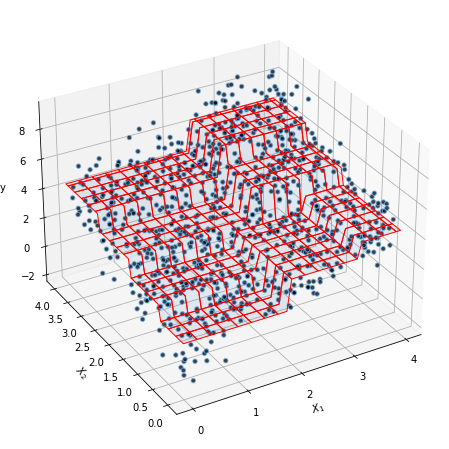

In [25]:
# create a meshgrid of points
fig = plt.figure(figsize=(8, 8))
x = X[:, 0]
z = X[:, 1]
x_pred = np.linspace(0, 4, 50)   # range of porosity values
z_pred = np.linspace(0, 4, 50)  # range of brittleness values
xx_pred, zz_pred = np.meshgrid(x_pred, z_pred)
model_viz = np.array([xx_pred.flatten(), zz_pred.flatten()]).T


#plt.style.use('default')

tree = BaseLineTree(criterion="mse",adaptive_complexity=True,max_depth=3).fit(X,y)
ax1 = fig.add_subplot(111, projection='3d')




samples = 10
predicted = tree.predict(model_viz)#tree.predict(model_viz)
axes = [ax1]
print(xx_pred.shape,zz_pred.shape, predicted.reshape(50,50).shape)
for ax in axes:
    ax.scatter(x, z, y, facecolor=(0,0,0,0), s=20, alpha=0.75,edgecolor='#70b3f0')
    ax.plot_surface(xx_pred, zz_pred, predicted.reshape(50,50), edgecolor='r',alpha=0.1, rcount=20,ccount=20)
    ax.set_xlabel('$X_1$', fontsize=10)
    plt.xticks(np.arange(0, 4.1, step=1))
    ax.set_ylabel('$X_2$', fontsize=10)
    ax.set_zlabel('y', fontsize=10)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')



ax1.view_init(elev=30, azim=-120)


#fig.tight_layout()
plt.show()

Text(0, 0.5, '$X_2$')

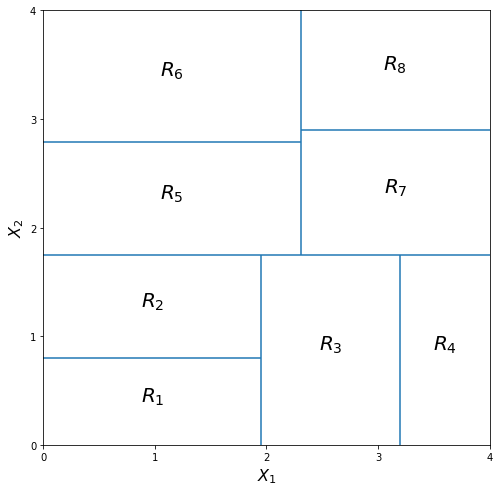

In [26]:
index = 1
def _draw_line(node,x_min = 0,x_max=4,y_min=0,y_max=4):
    global index
    x_min_next = x_min
    x_max_next = x_max
    y_min_next = y_min
    y_max_next = y_max
    if node.is_leaf():
        plt.text((x_max+x_min)/2, (y_max+y_min)/2,f"$R_{index}$", fontsize=20,ha='center') 
        index+=1
        return
    dim = node.get_split_feature()
    val = node.get_split_value()
    if dim==0:
        plt.vlines(x = val,ymin=y_min, ymax= y_max)
        x_min_next = val
        x_max_next = val
    else:
        plt.hlines(y = val,xmin=x_min, xmax=x_max)
        y_min_next = val
        y_max_next = val
    
    _draw_line(node.get_left_node(),x_min,x_max_next,y_min ,y_max_next )
    _draw_line(node.get_right_node(),x_min_next,x_max,y_min_next ,y_max)


node = tree.root
fig = plt.figure(figsize=(8, 8))
_draw_line(node)
plt.ylim(0,4)
plt.xlim(0,4)
plt.xticks(np.arange(0, 4.1, step=1))
plt.yticks(np.arange(0, 4.1, step=1))
plt.xlabel('$X_1$', fontsize=16)
plt.ylabel('$X_2$', fontsize=16)

In [27]:
kf = RepeatedKFold(n_splits= 5,n_repeats=20, random_state=SEED)
criterion = "mse"
models = {  
                "baseline": BaseLineTree(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True),
                "NU": NaiveUpdate(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True,),
                "TR":TreeReevaluation(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True, delta=0.1),
                "SR":StabilityRegularization(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True,lmbda=0.75),
                "ABU":AbuTreeI(criterion = criterion,min_samples_leaf=5,adaptive_complexity=True),
                "iABU": BootstrapUpdate(criterion = criterion,min_samples_leaf=5,adaptive_complexity=True)
                
                #  "baseline": BaseLineTree(**params), 
                # "NU": StableTree0(**params),
                #  "TR":TreeReevaluation(criterion = criterion,**params, delta=0.1)
                #  #"SR":StableTree2(**params,lmda=0.5),
                #  "ABU":AbuTreeI(**params)
                }

preds  = {k :np.zeros((200,100)) for k in models.keys()}
stability = {k :[] for k in models.keys()}
performance = {k :[] for k in models.keys()}
for i,(train_index, test_index) in enumerate(kf.split(X)):
        X_12, y_12 = X[train_index],y[train_index]
        X_test,y_test = X[test_index],y[test_index]
        X_test = np.sort(X_test)
        X1,X2,y1,y2 =  train_test_split(X_12, y_12, test_size=0.5, random_state=SEED)
        for name, model in models.items():
                model.fit(X1,y1)
                pred1 = model.predict(X_test)
                model.update(X_12,y_12)
                pred2 = model.predict(X_test)
                preds[name][:,i] = (pred1-pred2)**2
                stability[name].append( np.mean((pred1-pred2)**2))
                performance[name] = mean_squared_error(y_test, pred2)

0.02651994849831472


<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

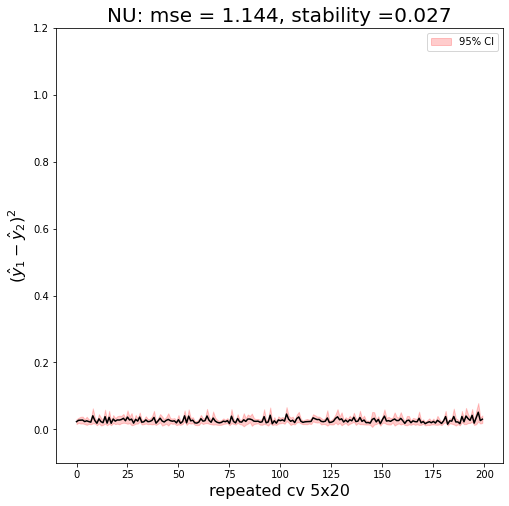

0.18706128670054784


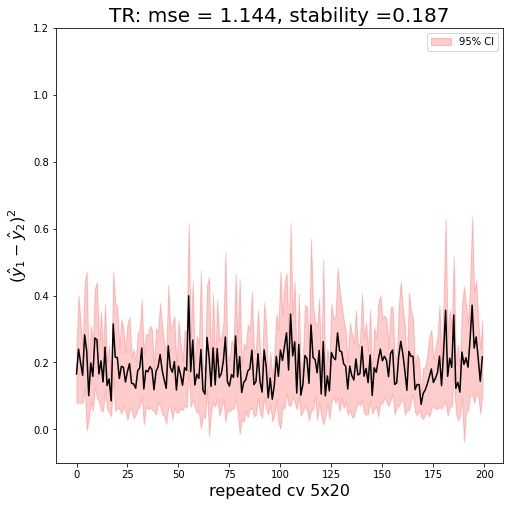

0.02797681995549012


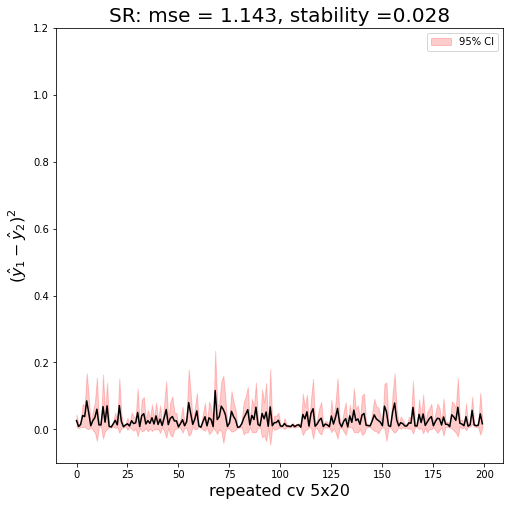

0.27375891181060885


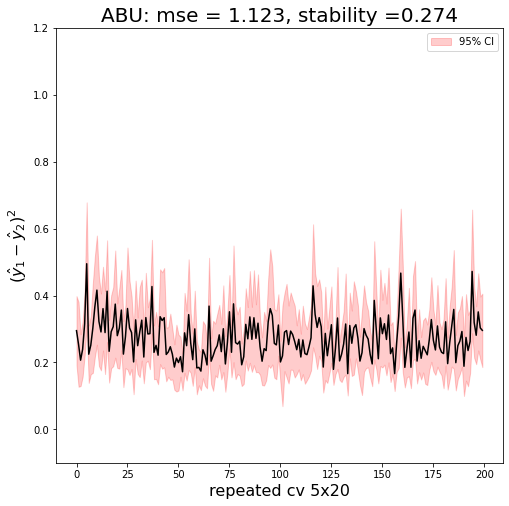

0.12015270635439135


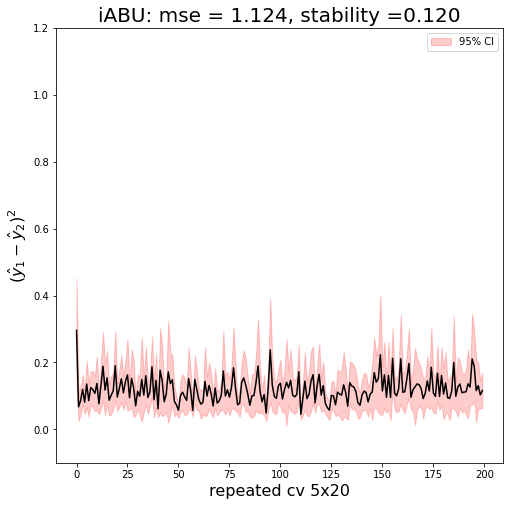

In [30]:
fig = plt.figure(figsize=(8, 8))
y_mean_base = np.mean(preds["baseline"],axis=1)
for i, (name, model) in enumerate(models.items()):
    fig = plt.figure(figsize=(8, 8))
    if i ==0:
        continue
    #plt.subplot(3,2,i)

    y_mean = np.mean(preds[name],axis=1)
    y_std = np.std(preds[name],axis=1)
    ci = 1.96 * y_std / np.sqrt(preds[name].shape[1])
    #plt.plot(np.arange(0,preds["baseline"].shape[0],1), y_mean_base, color = "blue")
    plt.plot(np.arange(0,preds[name].shape[0],1), y_mean, color = "black")
    plt.fill_between(np.arange(0,preds[name].shape[0],1), y_mean-ci, y_mean+ci, alpha=0.2, label='95% CI', color = "red", interpolate=True)
    plt.ylim((-0.1,1.2))
    # Set the plot title and axis labels
    plt.title('Line plot with error bars')
    plt.xlabel('repeated cv 5x20',fontsize=16)
    plt.ylabel('$(\hat{y}_1 - \hat{y}_2)^2$',fontsize=16)
    plt.title(f'{name}: mse = {np.mean(performance[name]):.3f}, stability ={np.mean(stability[name]):.3f}',fontsize=20)
    plt.legend()
    print(np.mean(np.mean(preds[name],axis=0)))
    plt.show()
    # Show the plot


0.3284189093221037


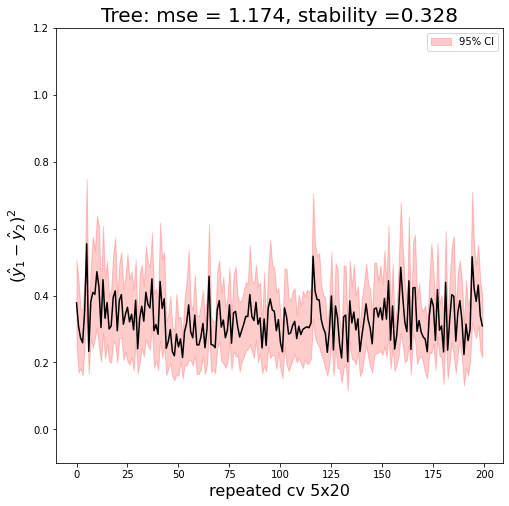

In [29]:
fig = plt.figure(figsize=(8, 8))
name = "baseline"
model  = models[name]


y_mean = np.mean(preds[name],axis=1)
y_std = np.std(preds[name],axis=1)
ci = 1.96 * y_std / np.sqrt(preds[name].shape[1])
plt.plot(np.arange(0,preds[name].shape[0],1), y_mean, color = "black")
plt.fill_between(np.arange(0,preds[name].shape[0],1), y_mean-ci, y_mean+ci, alpha=0.2, label='95% CI', color = "red", interpolate=True)
plt.ylim((-0.1,1.2))
# Set the plot title and axis labels
plt.xlabel('repeated cv 5x20',fontsize=16)
plt.ylabel('$(\hat{y}_1 - \hat{y}_2)^2$',fontsize=16)
plt.title(f'Tree: mse = {np.mean(performance[name]):.3f}, stability ={np.mean(stability[name]):.3f}',fontsize=20)
plt.legend()
print(np.mean(np.mean(preds[name],axis=0)))
    
    # Show the plot
plt.show()

# poisson

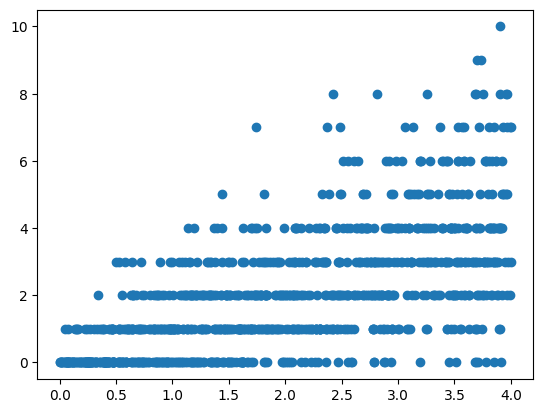

In [10]:
n = 1000
np.random.seed(SEED)
X = np.random.uniform(low=0,high=4,size=n).reshape(-1,1)
y = np.random.poisson(lam=X.ravel(),size=n)
plt.scatter(X,y)
plt.show()

In [11]:
kf = RepeatedKFold(n_splits= 5,n_repeats=20, random_state=SEED)
criterion = "poisson"
models = {  
                "baseline": BaseLineTree(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True),
                "NU": NaiveUpdate(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True,),
                "TR":TreeReevaluation(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True, delta=0.1),
                "SR":StabilityRegularization(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True,lmbda=0.75),
                "ABU":AbuTreeI(criterion = criterion,min_samples_leaf=5,adaptive_complexity=True)
                
                #  "baseline": BaseLineTree(**params), 
                # "NU": StableTree0(**params),
                #  "TR":TreeReevaluation(criterion = criterion,**params, delta=0.1)
                #  #"SR":StableTree2(**params,lmda=0.5),
                #  "ABU":AbuTreeI(**params)
                }

preds  = {k :np.zeros((200,100)) for k in models.keys()}
stability = {k :[] for k in models.keys()}
performance = {k :[] for k in models.keys()}
for i,(train_index, test_index) in enumerate(kf.split(X)):
        X_12, y_12 = X[train_index],y[train_index]
        X_test,y_test = X[test_index],y[test_index]
        X_test = np.sort(X_test)
        X1,X2,y1,y2 =  train_test_split(X_12, y_12, test_size=0.5, random_state=SEED)
        for name, model in models.items():
                model.fit(X1,y1)
                pred1 = model.predict(X_test)
                model.update(X_12,y_12)
                pred2 = model.predict(X_test)
                preds[name][:,i] = np.log((pred2+1.1)/(pred1+1.1)) #np.std(np.log((pred2+EPSILON)/(pred1+EPSILON)))
                stability[name].append( np.std(np.log((pred2+1.1)/(pred1+1.1))))
                performance[name] = mean_poisson_deviance(y_test+0.001, pred2+0.001)

0.10523990108792917
0.03358028351841121
0.03358028351841121
0.0552381306445934
0.1351971669835862


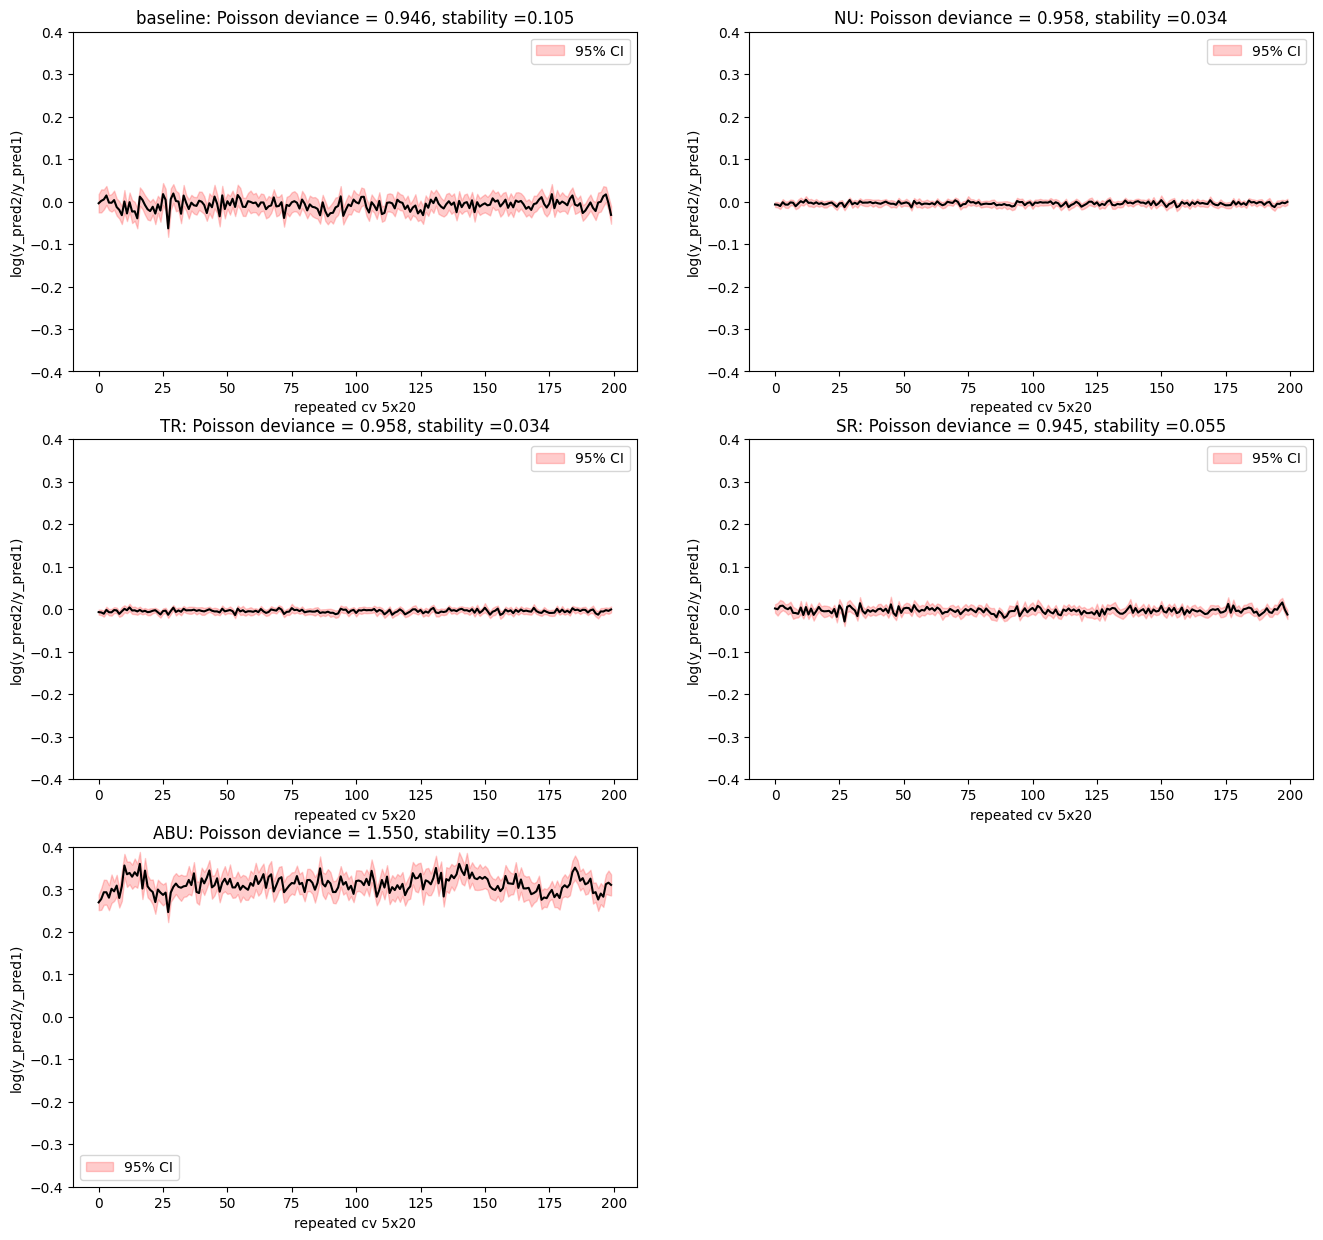

In [12]:
fig = plt.figure(figsize=(16, 15))
for i, (name, model) in enumerate(models.items()):
    plt.subplot(3,2,i+1)

    y_mean = np.mean(preds[name],axis=1)
    y_std = np.std(preds[name],axis=1)
    ci = 1.96 * y_std / np.sqrt(preds[name].shape[1])
    plt.plot(np.arange(0,preds[name].shape[0],1), y_mean, color = "black",)
    plt.fill_between(np.arange(0,preds[name].shape[0],1), y_mean-ci, y_mean+ci, alpha=0.2, label='95% CI', color = "red", interpolate=True)
    plt.ylim((-0.4,0.4))
    # Set the plot title and axis labels
    plt.xlabel('repeated cv 5x20')
    plt.ylabel('log(y_pred2/y_pred1)')
    plt.title(f'{name}: Poisson deviance = {np.mean(performance[name]):.3f}, stability ={np.mean(stability[name]):.3f}')
    plt.legend()
    print(np.mean(stability[name]))
    # Show the plot
plt.show()

In [13]:
np.exp(preds["ABU"])

array([[1.2558839 , 1.25709512, 1.38560497, ..., 1.36230213, 1.2436951 ,
        1.32688312],
       [0.83794733, 1.20752467, 1.38560497, ..., 1.23760387, 1.37019856,
        1.21936165],
       [1.20225503, 1.25709512, 1.38560497, ..., 1.77583528, 1.2436951 ,
        1.21936165],
       ...,
       [1.34420069, 1.43109916, 1.38560497, ..., 1.23760387, 1.37019856,
        1.21936165],
       [1.34420069, 1.54123668, 1.50979172, ..., 1.55562006, 1.2436951 ,
        1.53403658],
       [1.2558839 , 1.54123668, 1.17400277, ..., 1.36230213, 1.2436951 ,
        1.73219311]])

In [14]:
np.exp(preds["baseline"])

array([[0.98833139, 0.97499423, 1.11463377, ..., 1.06261754, 0.91996951,
        0.97589336],
       [1.32579338, 1.01994277, 1.11463377, ..., 1.14407715, 0.90833999,
        0.87231222],
       [0.95851137, 0.78345071, 1.11463377, ..., 0.96854834, 1.15679443,
        1.04538671],
       ...,
       [1.02411498, 1.02268954, 1.11463377, ..., 1.14407715, 1.1138546 ,
        1.04538671],
       [1.02411498, 1.08437104, 0.97399868, ..., 1.06940801, 0.91996951,
        1.05306476],
       [0.98833139, 1.08437104, 0.84201038, ..., 1.06261754, 0.91996951,
        0.96522074]])

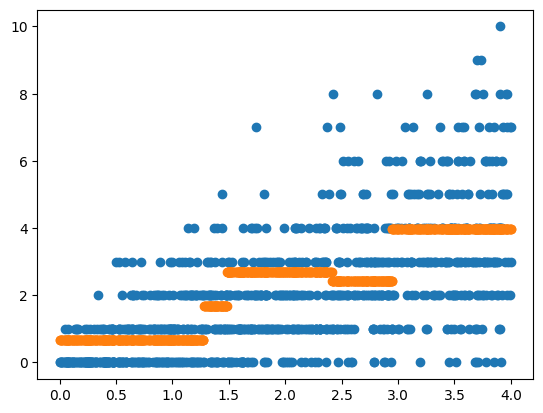

In [15]:
plt.scatter(X,y)
plt.scatter(X,(tree.predict(X)))

In [16]:
tree = AbuTreeI(criterion = criterion,min_samples_leaf=5,adaptive_complexity=True).fit(X,y)

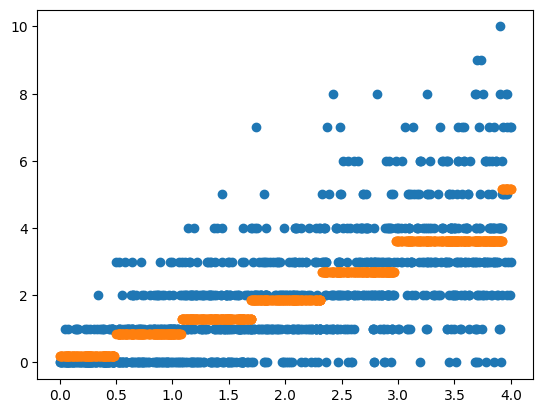

In [17]:
plt.scatter(X,y)
plt.scatter(X,(tree.predict(X)))

In [18]:
preds

{'baseline': array([[-0.01173722, -0.02532372,  0.10852589, ...,  0.06073525,
         -0.08341475, -0.02440196],
        [ 0.28201106,  0.01974652,  0.10852589, ...,  0.13459833,
         -0.09613653, -0.13660787],
        [-0.04237385, -0.24404712,  0.10852589, ..., -0.03195688,
          0.14565275,  0.04438688],
        ...,
        [ 0.02382881,  0.02243596,  0.10852589, ...,  0.13459833,
          0.10782661,  0.04438688],
        [ 0.02382881,  0.08100013, -0.02634533, ...,  0.06710523,
         -0.08341475,  0.05170473],
        [-0.01173722,  0.08100013, -0.17196294, ...,  0.06073525,
         -0.08341475, -0.03539846]]),
 'NU': array([[ 0.00734598, -0.04650256,  0.01359006, ..., -0.00461471,
         -0.00101678, -0.02440196],
        [-0.00573973,  0.01188091,  0.01359006, ...,  0.00631448,
         -0.01745566, -0.02852158],
        [-0.00973661, -0.04650256,  0.01359006, ..., -0.03195688,
         -0.00101678, -0.02852158],
        ...,
        [-0.00573973,  0.03228593,  